In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
tab = matplotlib.cm.get_cmap('tab10')
import os
from glob import glob

import pandas as pd

from itertools import groupby
import h5py

plt.rcParams['text.usetex'] = False
from scipy.optimize import curve_fit

/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_83704/1859429441.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab = matplotlib.cm.get_cmap('tab10')


In [5]:
dt_base = 1.25e-4 #sec
dx = 0.03 #um

#set so that bessel function produces the same diffusion coef as
#   a cluster of size 50 in the fast-diffusing D ~ 1/N_mol model
D_LAT = 0.043125 #um^2/s

k_bind_base = 0.072 #s^-1
k_unbind = k_bind_base/32 #s^-1

t_factor =  [1, 1, 1, 2, 10]
on_factor = [1, 3, 9, 1, 1]
frac_filled = [(2**i)/(512*5) for i in range(10)]

N_reps = 500
tot_jobs = 2000
N_job = np.zeros([5,10])
for i,t in enumerate(t_factor):
    for ii,frac in enumerate(frac_filled):
        N_job[i,ii] = (frac*t)
N_job = tot_jobs*N_job/np.sum(N_job) #target number of jobs for each condition
N_job = N_job/1.5

tracker = N_job.copy()
done = np.zeros([5,10]).astype(bool)
for n in [1,2,4,5,10,20,25,50,100,125,250,500]:
    idxs = (tracker < n) & (~done)
    N_job[idxs] = n
    done[idxs] = True
N_job = N_job.astype(int)
N_per = (N_reps/N_job).astype(int)
print(N_job.astype(int))
print(N_per.astype(int))
print(np.sum(N_job))

[[  1   1   1   1   2   4  10  20  25  50]
 [  1   1   1   1   2   4  10  20  25  50]
 [  1   1   1   1   2   4  10  20  25  50]
 [  1   1   1   2   4  10  20  25  50 100]
 [  1   2   4  10  20  50 100 125 250 500]]
[[500 500 500 500 250 125  50  25  20  10]
 [500 500 500 500 250 125  50  25  20  10]
 [500 500 500 500 250 125  50  25  20  10]
 [500 500 500 250 125  50  25  20  10   5]
 [500 250 125  50  25  10   5   4   2   1]]
1621


In [3]:
with open('cmds.sh','w') as f:
    
    for i,(t,on) in enumerate(zip(t_factor,on_factor)):
        for fr,frac in enumerate(frac_filled):

            kws = {'init_kws':{'density_0':frac/(dx**2), #convert to um^-2
                               'density_1':0,
                               'source_locs':np.zeros([1,4])},

                   'diffusion_kws':{'D_LAT':D_LAT,
                                    'dx':dx*1000}, #nm
                                       #always 30 becuase this is only used for cluster radius calculations

                   'update_binding_kws':{'k_bind':on*k_bind_base,
                                         'k_unbind':k_unbind},
                   
                   'update_exist_kws':{},

                   'num_mols':{},
                   'cluster_size_distribution':{'max_cluster_size':5}
                  }

            pkl.dump(kws, open(f'kws/t{t}_on{on}_frac{fr}_kws.pkl','wb'))

            for j in range(N_job[i,fr]):
                f.write('python ../../code/LAT_cluster_sim.py '+\
                        f'-N {N_per[i,fr]} '+\
                        f'-T 30 -dt {dt_base/t} '+ #this represents 30s of real time
                        f'-grid_size {151*dx_base} -dx {dx} '+\
                        f'-record_every_Nth {int(0.025/(dt_base/t))} '+ #recording every 0.025s
                        '-write_every_Nth 100 '+\
                        '-N_save 0 '+\
                        '-summary_funcs cluster_size_distribution num_mols '+\
                        '-binding_function binding_only_dimers '+\
                        '-init_function initialize_random '+\
                        f'-update_exist_function create_none '+\
                        '-diffusion_function diffusion_bessel_push '+\
                        f'-kw_pkl kws/t{t}_on{on}_frac{fr}_kws.pkl '+\
                        f'-outfile_base results/t{t}_on{on}_frac{fr}_{j}\n')

In [3]:
complete = np.zeros([5,10,500])

for i,(t,on) in enumerate(zip(t_factor,on_factor)):
    for fr,frac in enumerate(frac_filled):
        for j in range(N_job[i,fr]):
            try:
                data = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                 'r')['num_mols'][:]
            except FileNotFoundError:
                continue
            complete[i,fr,j*N_per[i,fr]:(j+1)*N_per[i,fr]] = np.any(data[:,-100:]!=0,axis=1)

complete = complete.astype(bool)
print(N_reps - np.sum(complete,axis=2))

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [4]:
T = np.array(range(0,1201))/40

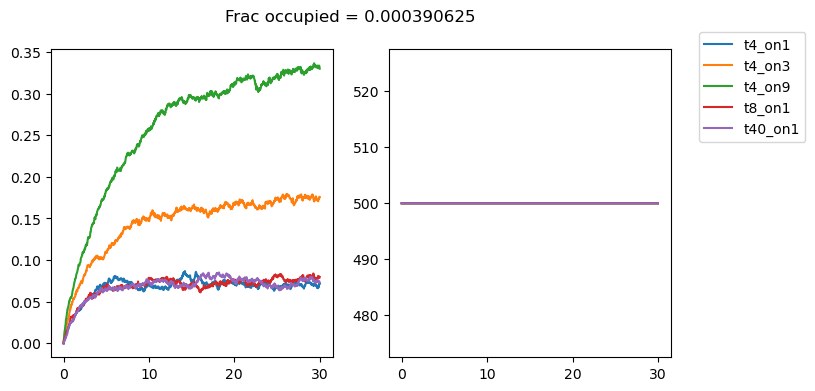

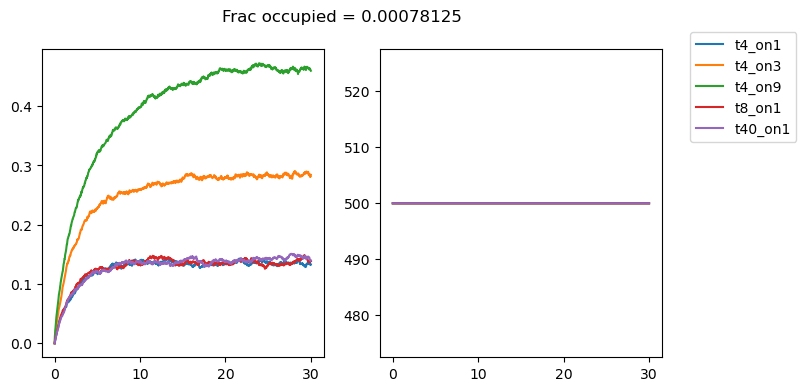

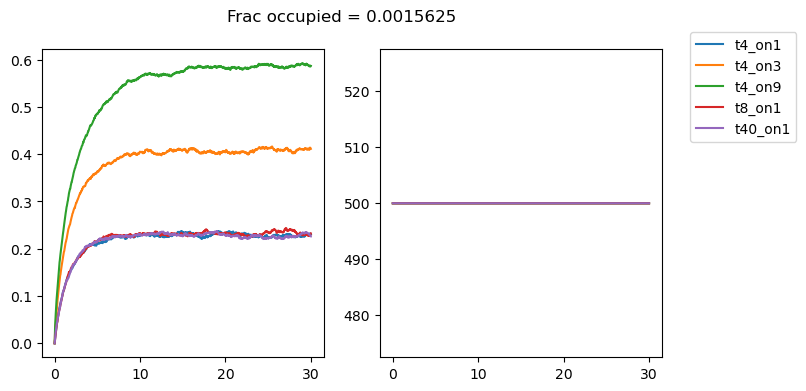

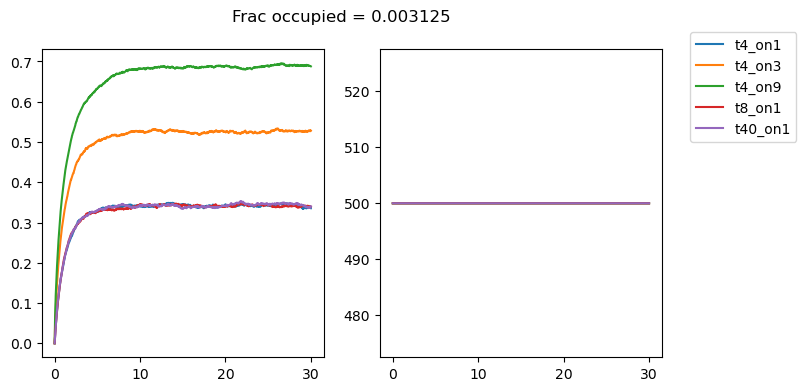

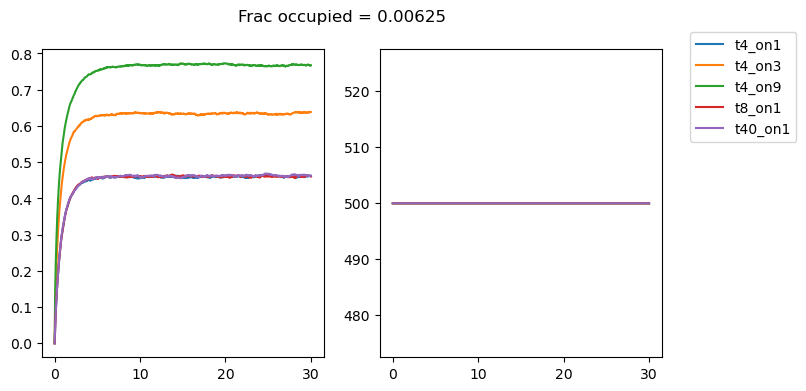

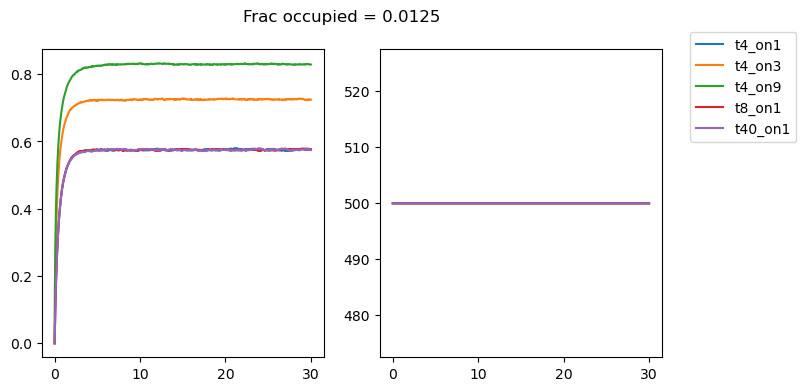

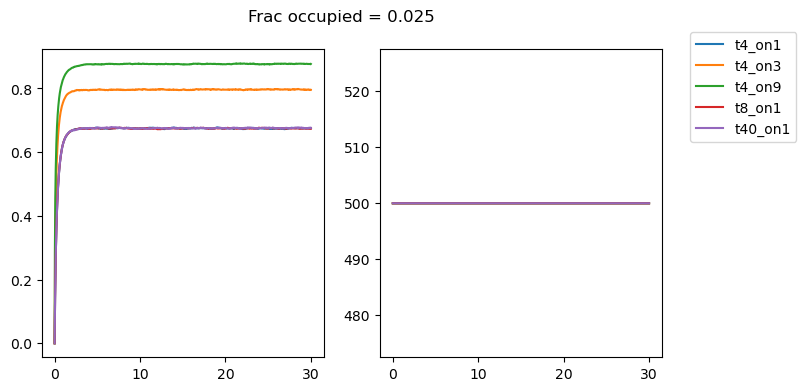

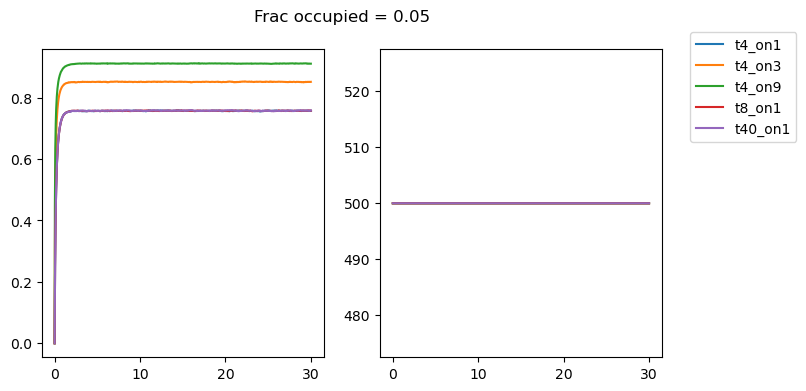

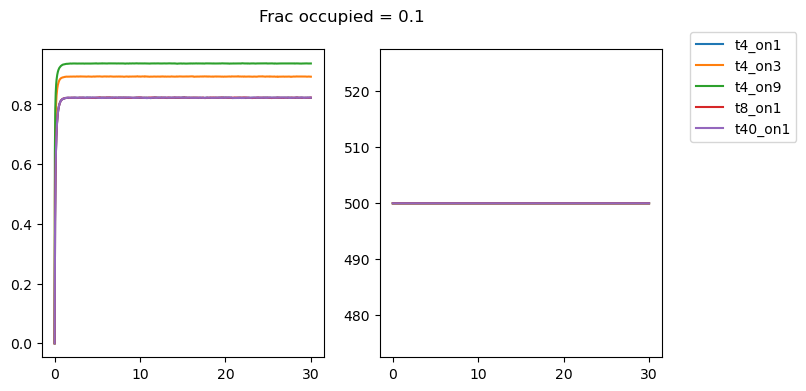

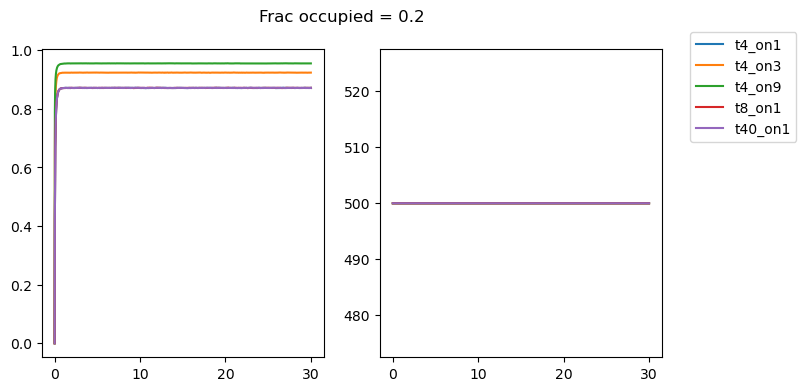

In [5]:
for fr,frac in enumerate(frac_filled):
    plt.figure(figsize=[8,4])
    for i,(t,on) in enumerate(zip(t_factor,on_factor)):
        size_distr = np.zeros([500,1201,5])
        nmol = np.zeros([500,1201])
        for j in range(N_job[i,fr]):
            try:
                size_distr[j*N_per[i,fr]:(j+1)*N_per[i,fr],:,:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                                'r')['cluster_size_distribution'][:]
                nmol[j*N_per[i,fr]:(j+1)*N_per[i,fr],:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                                'r')['num_mols'][:]
            except FileNotFoundError:
                continue
        
#         print(f"t{t}_on{on}_frac{fr}: {np.sum(size_distr[:,:,2:]>0,axis=None)}")
        N_missing = N_reps - np.sum(np.any(nmol[:,-100:]!=0,axis=1))
#         print(f"t{t}_on{on}_frac{fr}: {N_missing}")
        
        plt.subplot(1,2,1)
        if not N_missing:
            plt.plot(T,np.mean(size_distr[:,:,1],axis=0),label=f't{t}_on{on}')
            
        plt.subplot(1,2,2)
        plt.plot(T,np.sum(nmol>0,axis=0),label=f't{t}_on{on}')
        
    plt.suptitle(f'Frac occupied = {frac}')
    plt.legend(loc=[1.1,0.7])

In [6]:
def line(x,slope):
    return x*slope

In [23]:
summary_mono = {}
summary_mono['time'] = T

summary_di = {}
summary_di['time'] = T
for fr,frac in enumerate(frac_filled):
    for i,(t,on) in enumerate(zip(t_factor,on_factor)):
        size_distr = np.zeros([500,1201,5])
        nmol = np.zeros([500,1201])
        for j in range(N_job[i,fr]):
            size_distr[j*N_per[i,fr]:(j+1)*N_per[i,fr],:,:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                            'r')['cluster_size_distribution'][:]
            nmol[j*N_per[i,fr]:(j+1)*N_per[i,fr],:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                            'r')['num_mols'][:]
            
        summary_mono[f't{t}_on{on}_frac{fr}'] = np.mean(nmol*size_distr[:,:,0]/((151*0.03)**2),axis=0)
        summary_di[f't{t}_on{on}_frac{fr}'] = np.mean(nmol*size_distr[:,:,1]/((151*0.03)**2),axis=0)/2
summary_mono = pd.DataFrame(summary_mono)
summary_di = pd.DataFrame(summary_di)

In [24]:
summary_mono.head()

,time,t4_on1_frac0,t4_on3_frac0,t4_on9_frac0,t8_on1_frac0,t40_on1_frac0,t4_on1_frac1,t4_on3_frac1,t4_on9_frac1,t8_on1_frac1,...,t4_on1_frac8,t4_on3_frac8,t4_on9_frac8,t8_on1_frac8,t40_on1_frac8,t4_on1_frac9,t4_on3_frac9,t4_on9_frac9,t8_on1_frac9,t40_on1_frac9
0,0.000,0.438675,0.425517,0.435946,0.438772,0.436238,0.866629,0.863900,0.863900,0.864777,...,111.172999,111.054096,111.159647,111.176995,111.173292,222.267249,222.381669,222.171835,222.321146,222.082072
1,0.025,0.438090,0.424543,0.434191,0.437992,0.435848,0.864874,0.859027,0.853179,0.862438,...,81.800213,58.320541,40.640128,81.743198,81.813176,127.760283,76.758622,46.826699,128.012612,127.666136
2,0.050,0.437310,0.423763,0.432242,0.437408,0.435458,0.862730,0.853569,0.849280,0.861073,...,66.063087,42.666647,29.367718,66.031217,66.084626,92.359692,51.159744,32.148590,92.458226,92.354624
3,0.075,0.437115,0.422204,0.431073,0.437018,0.435458,0.860391,0.849280,0.844992,0.858149,...,56.029414,34.530552,23.758802,55.972594,56.045690,73.559932,39.966083,25.688834,73.719671,73.629519
4,0.100,0.436920,0.421619,0.429708,0.436823,0.435069,0.859806,0.845772,0.840509,0.856590,...,48.946879,29.497439,20.326399,48.902923,49.037615,62.111701,33.738871,21.968335,62.237914,62.110921


/tmp/ipykernel_28005/1006292278.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


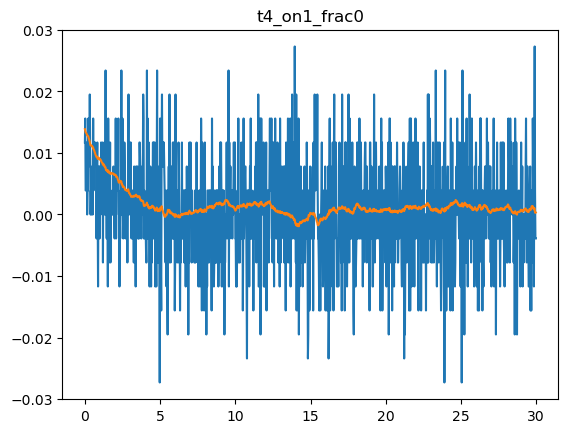

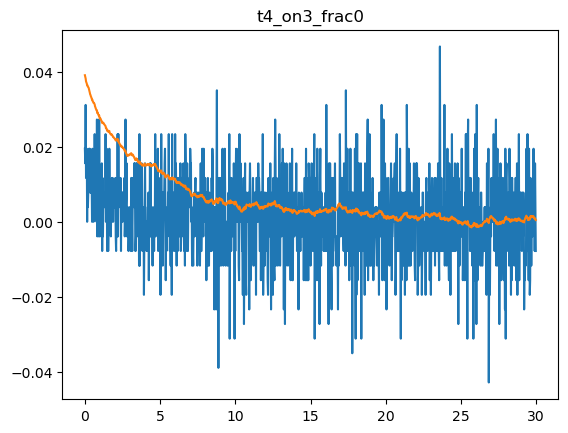

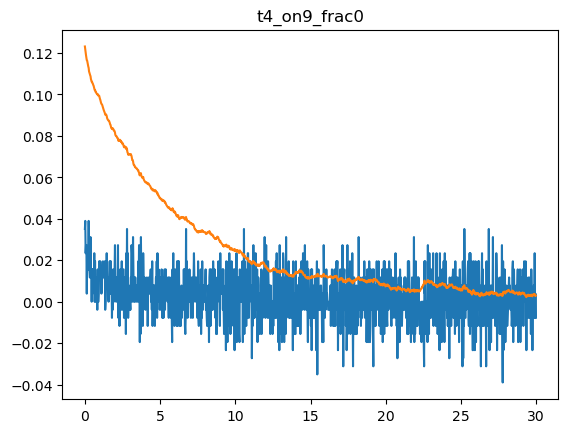

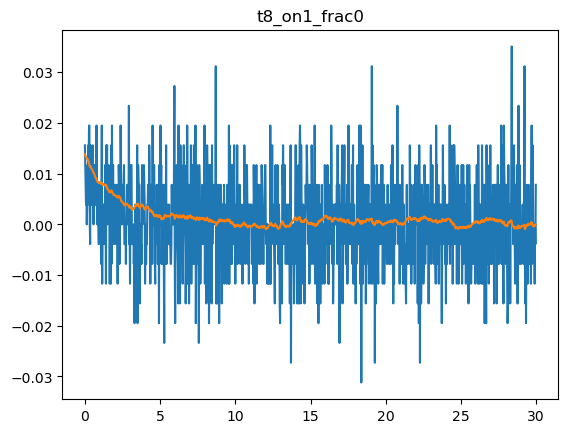

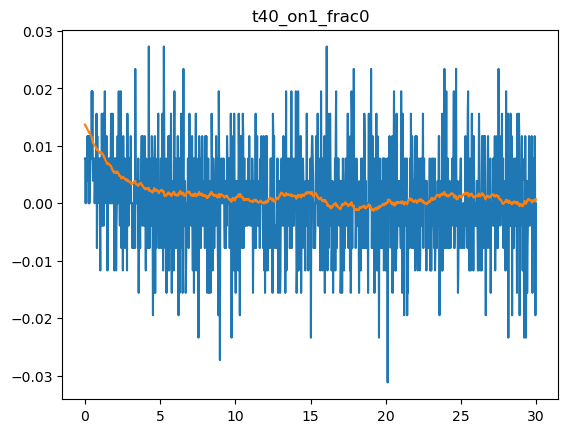

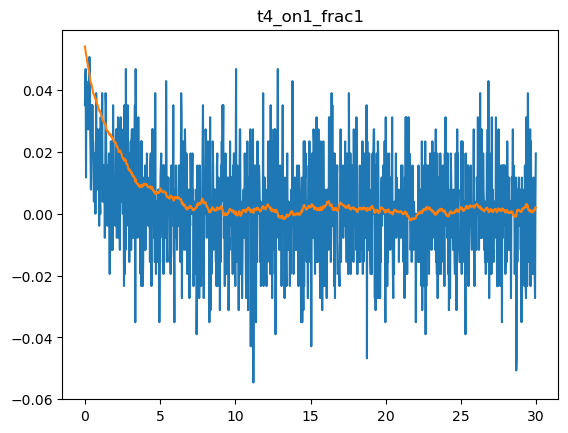

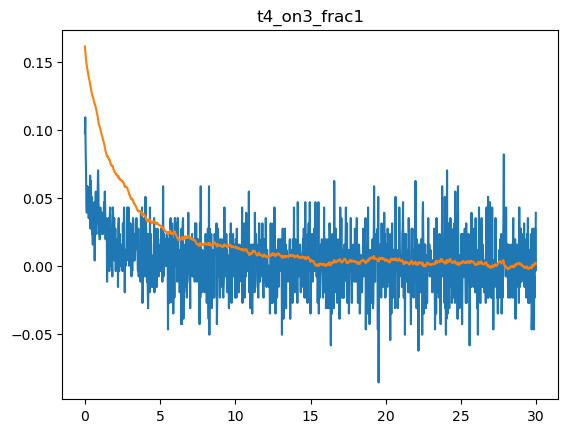

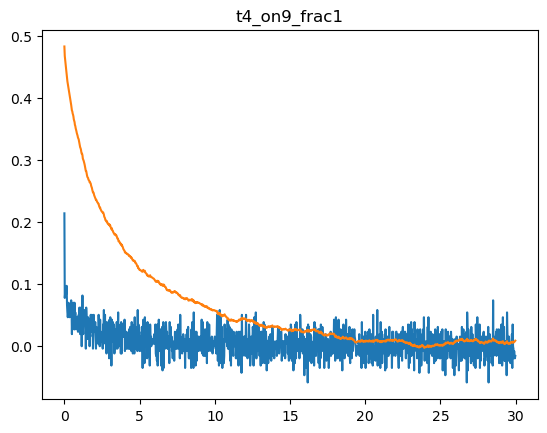

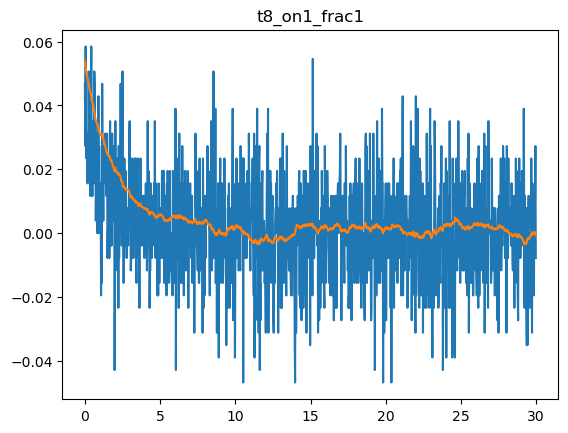

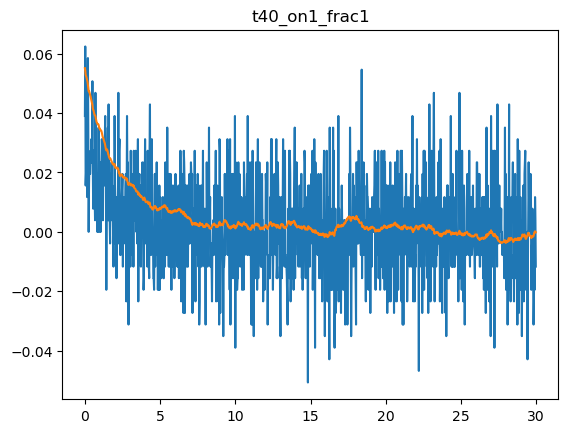

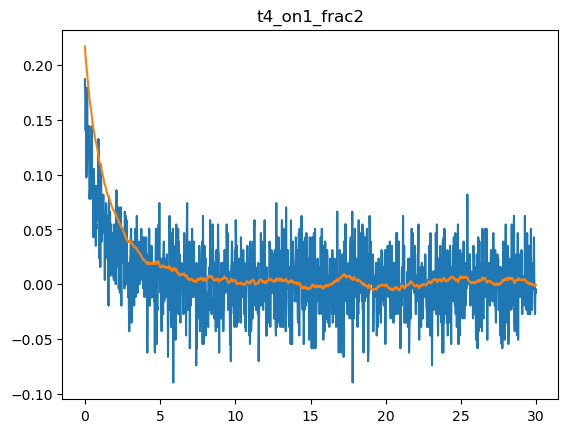

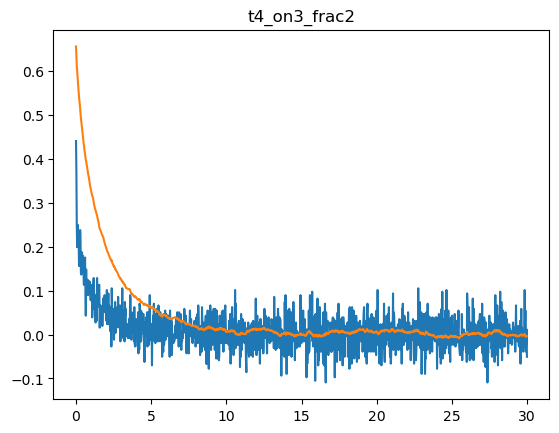

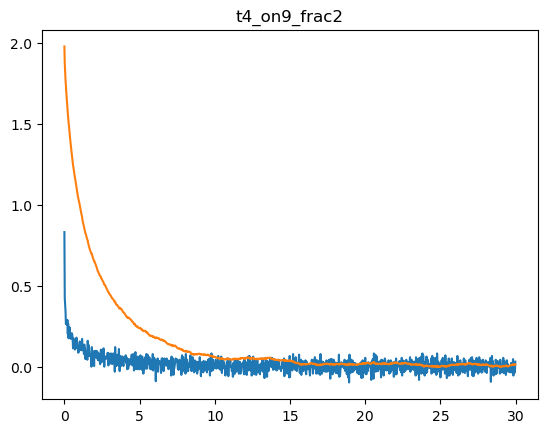

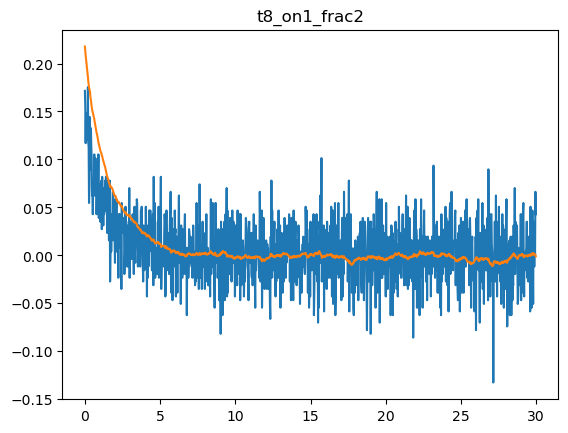

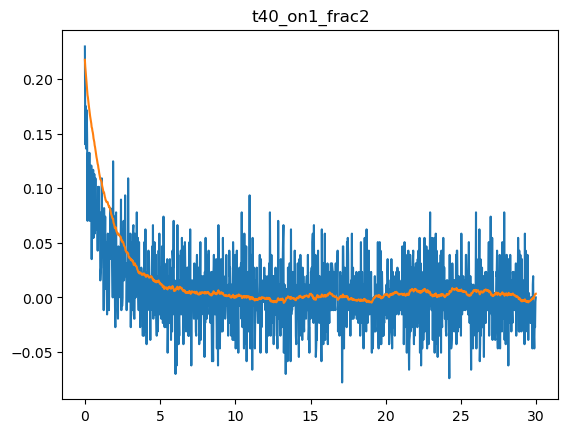

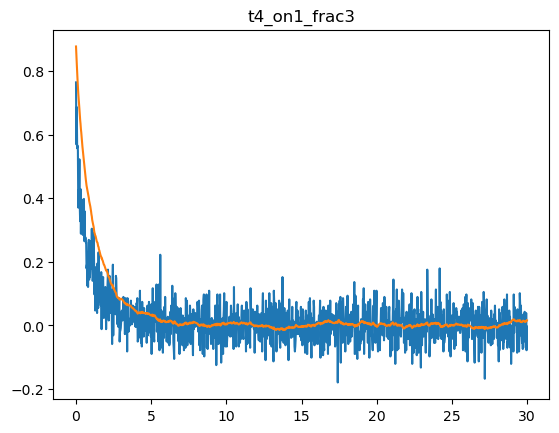

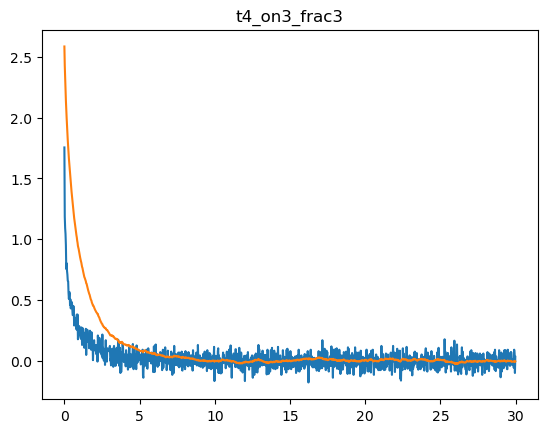

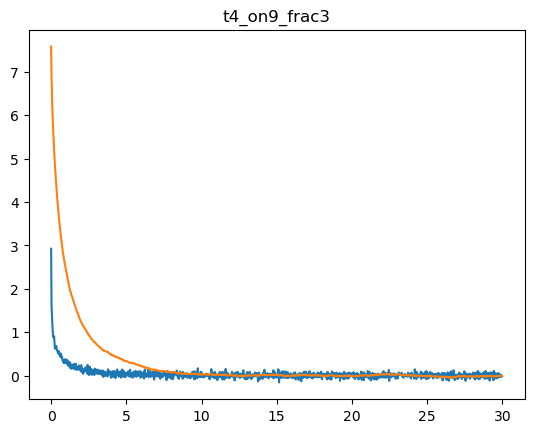

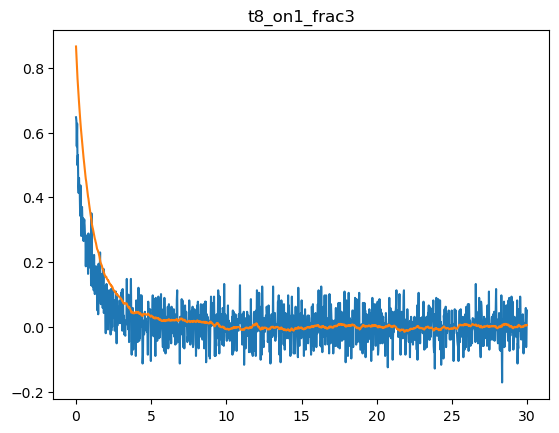

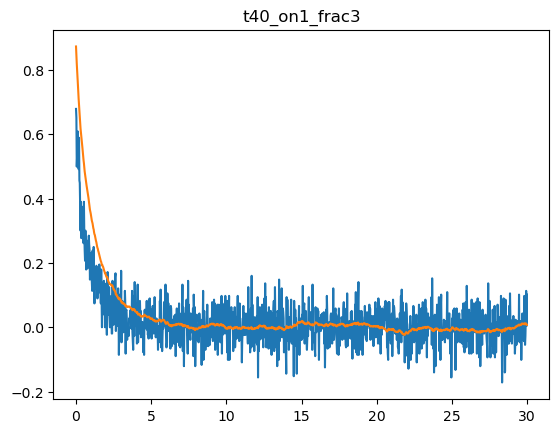

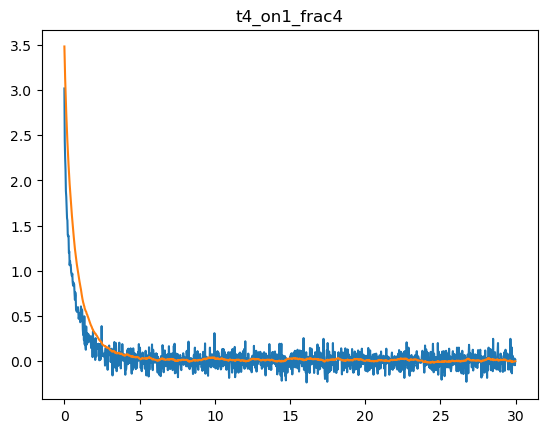

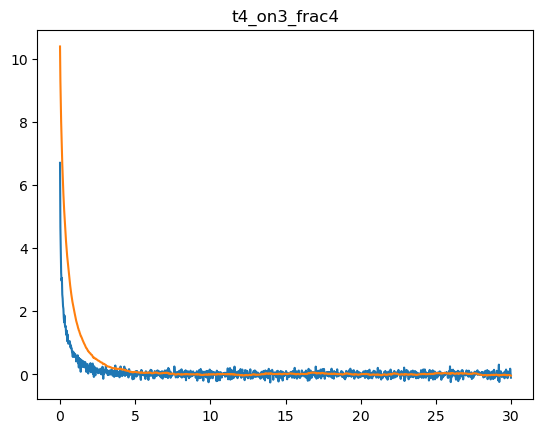

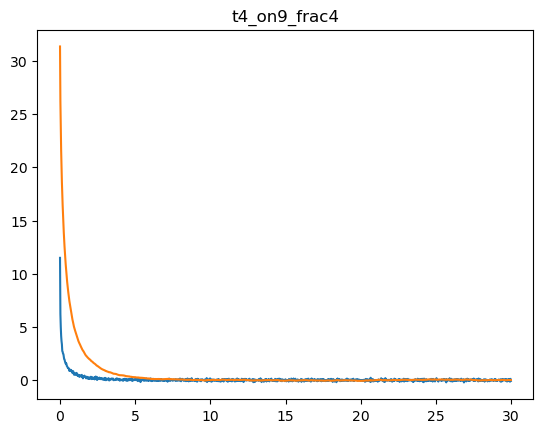

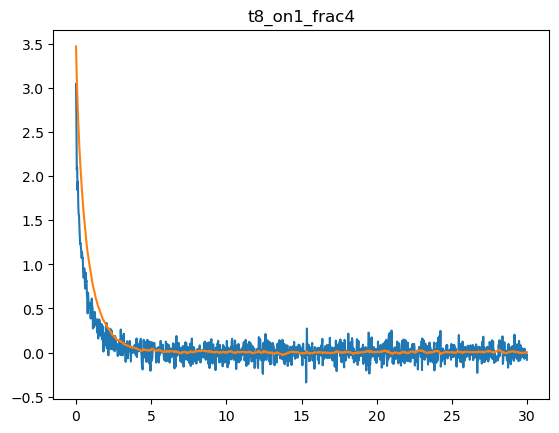

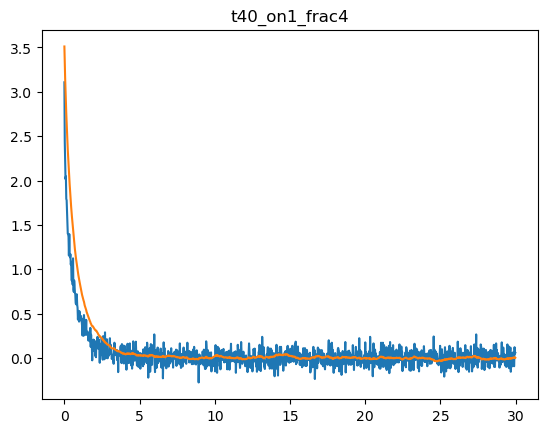

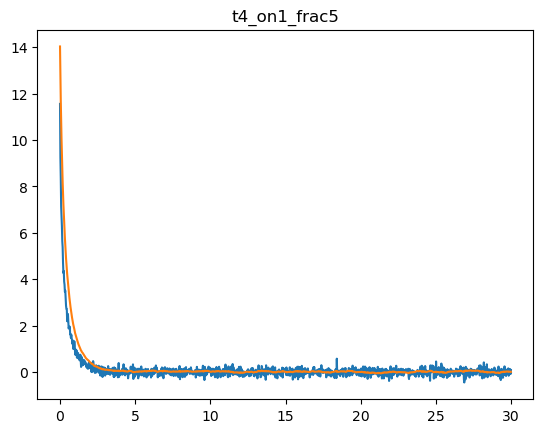

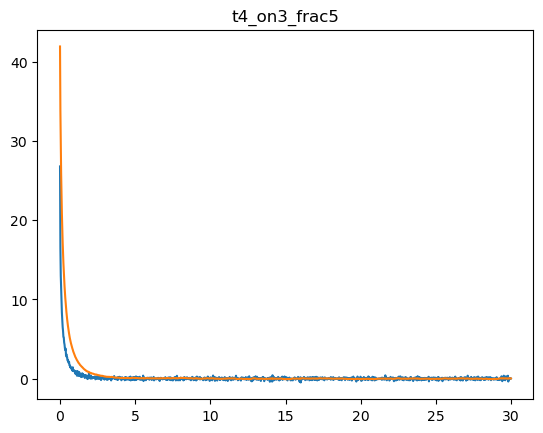

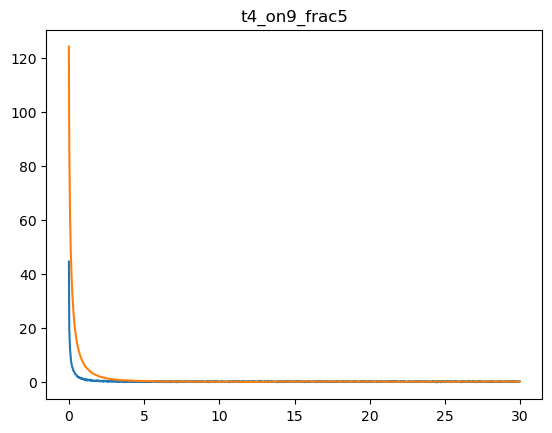

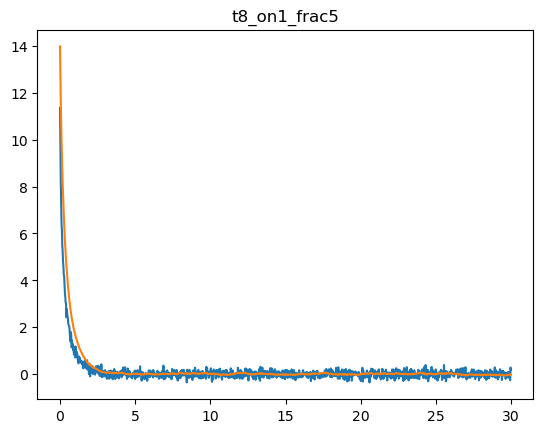

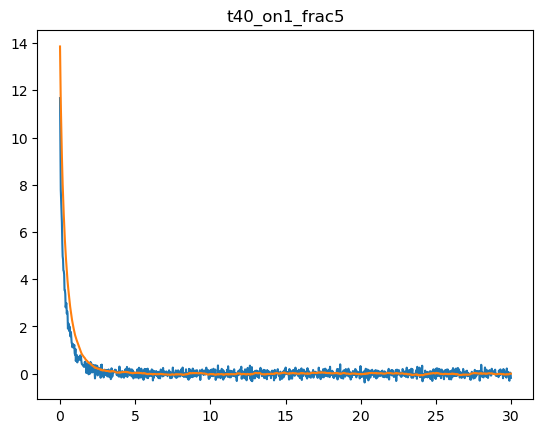

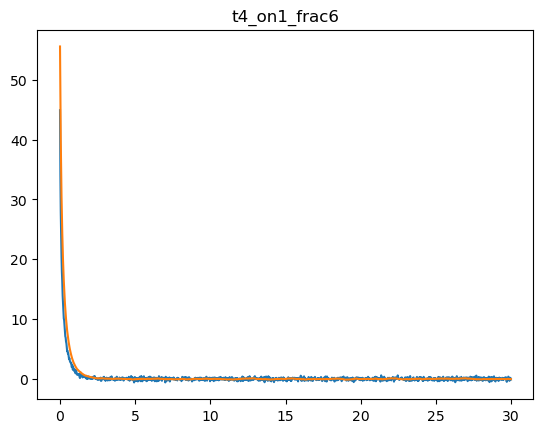

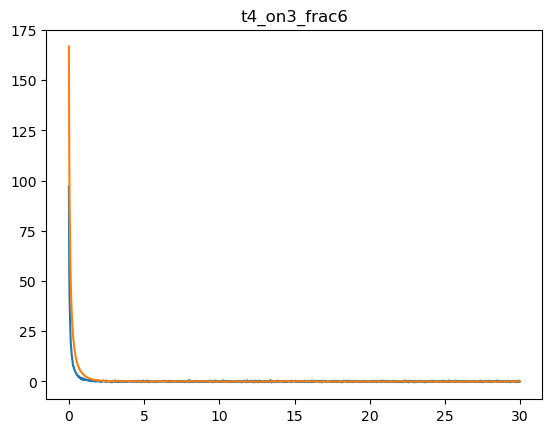

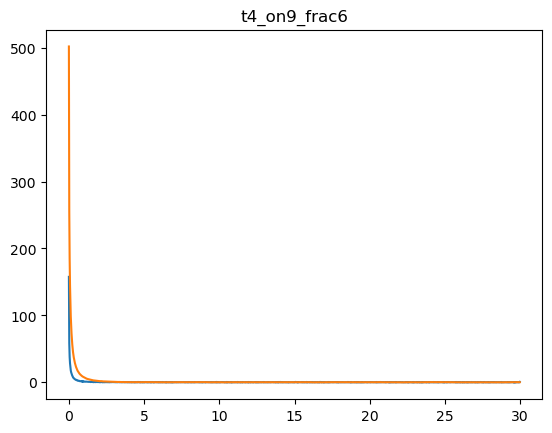

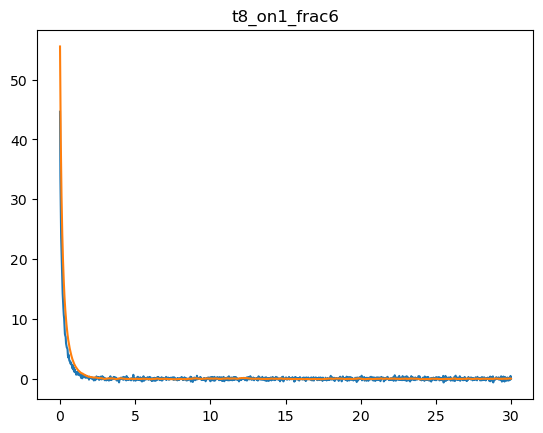

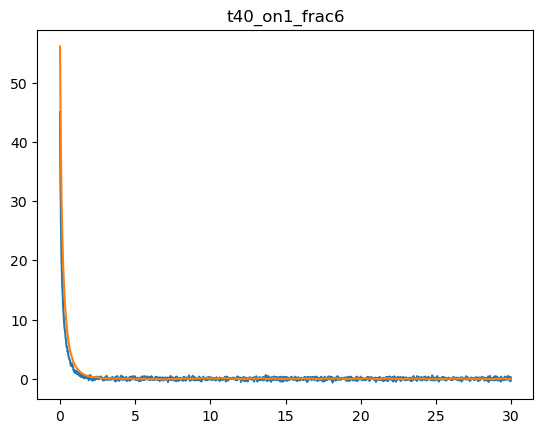

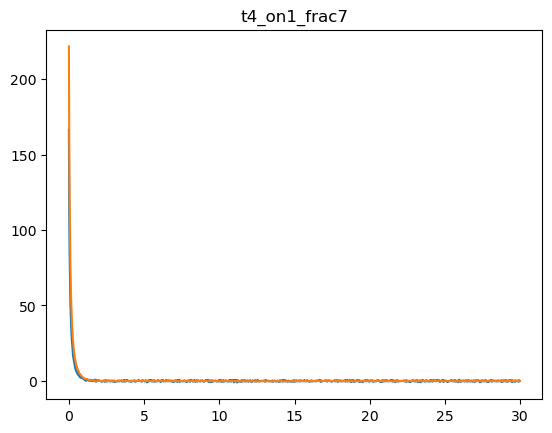

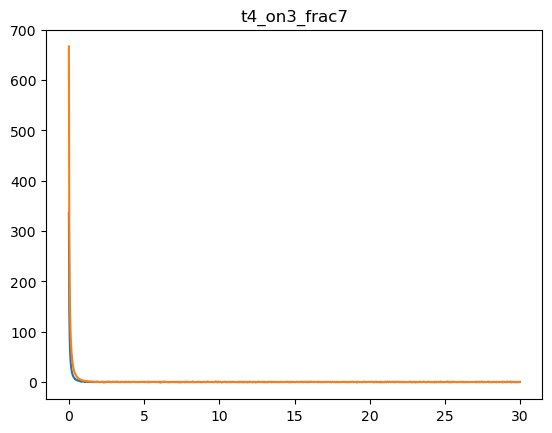

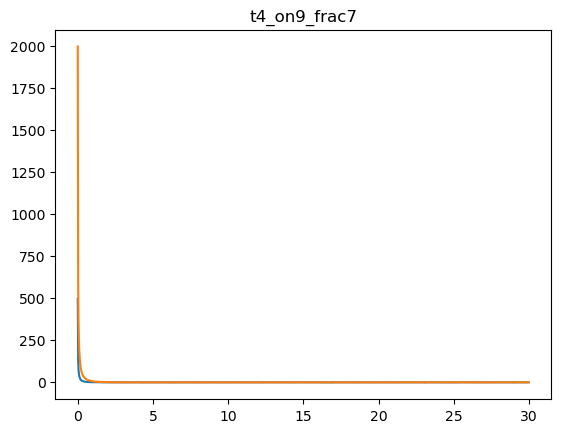

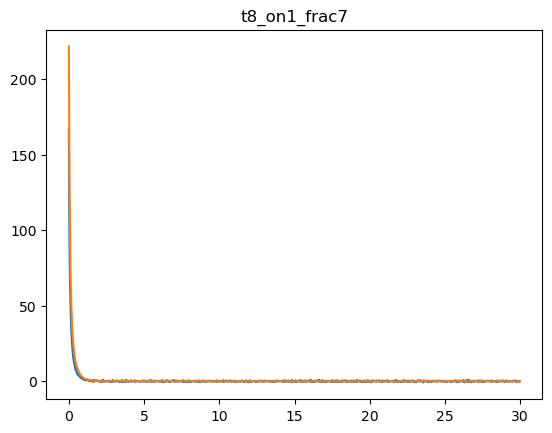

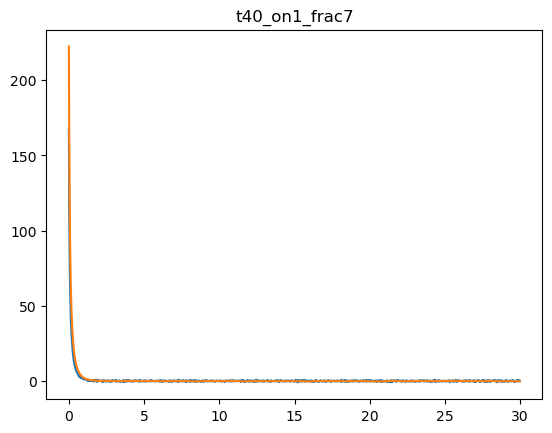

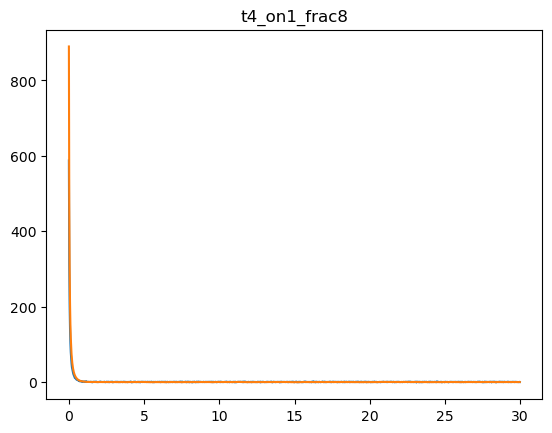

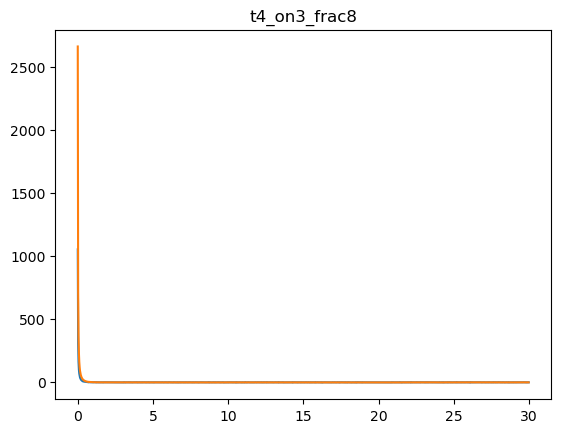

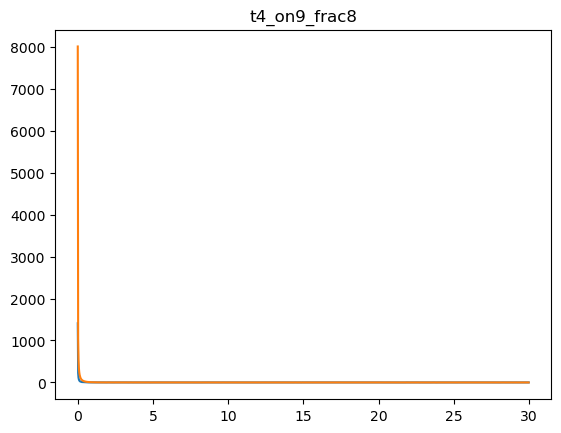

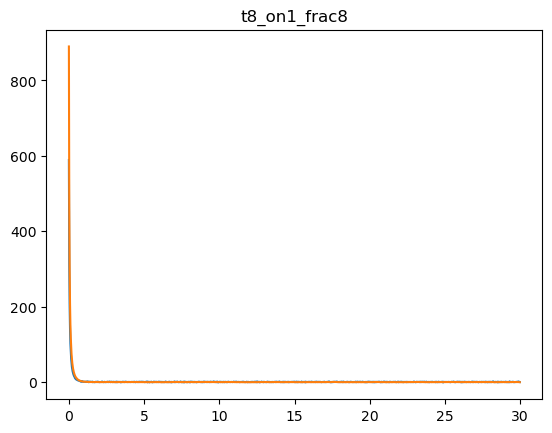

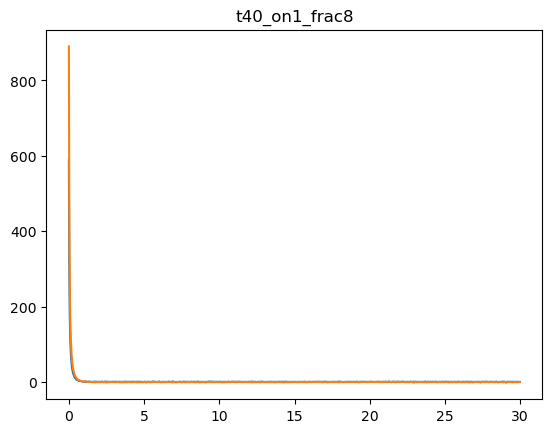

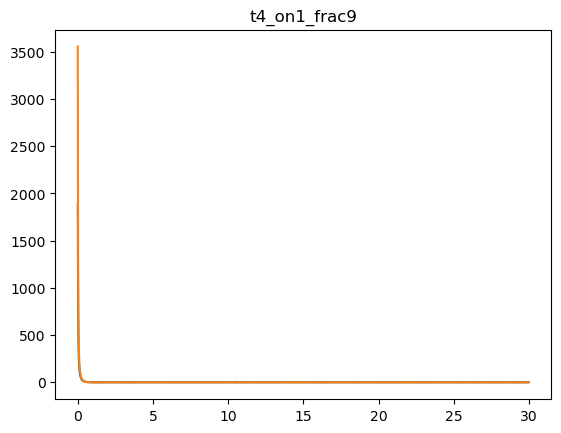

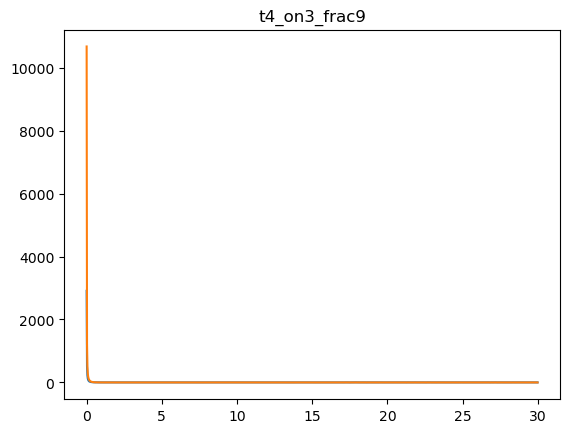

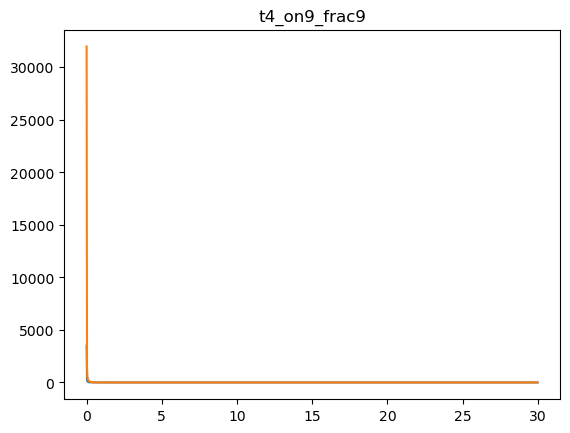

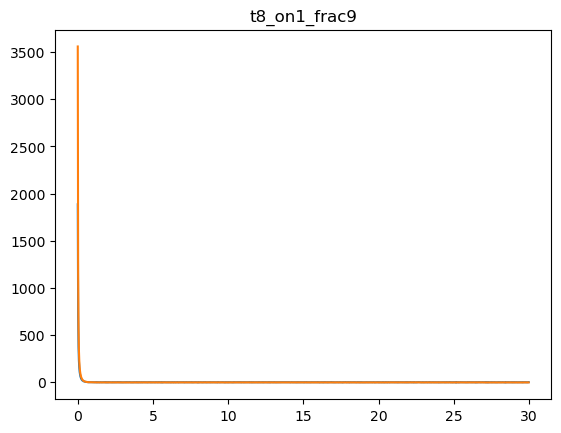

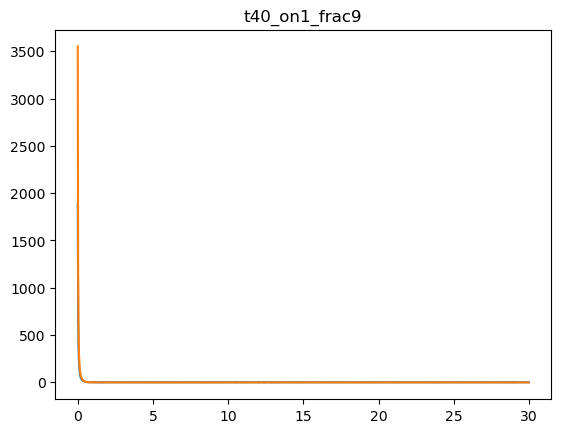

In [31]:
k_off = p_unbind*(240000/120)
for col in summary_di.columns[1:]:
    t = int(col.split('_')[0].replace('t',''))
    k_on = 4*p_bind_base*float(col.split('_')[1].replace('on',''))*(240000/120)*(0.03**2)
    C_tot = frac_filled[int(col.split('_')[-1].replace('frac',''))]/(0.03**2)
        
    A_eqm = np.mean(summary_mono[col].values[-500:])
    B_eqm = np.mean(summary_di[col].values[-500:])
    k_on_eqm = (k_off*C_tot - k_off*A_eqm)/(2*(A_eqm**2))
    
    pred = k_on*(summary_mono[col].values[:-1]**2) - k_off*summary_di[col].values[:-1]
    real = (summary_di[col].values[1:] - summary_di[col].values[:-1])/0.025
    
    plt.figure()
    plt.plot(summary_di['time'].values[:-1],real)
    plt.plot(summary_di['time'].values[:-1],pred)
    plt.title(col)
    
#     print((A_eqm+(2*B_eqm))/C_tot)
        
#     eqm_A = (np.sqrt(k_off**2 + 8*k_on*k_off*C_tot) - k_off)/(4*k_on)
#     eqm_B = (C_tot - eqm_A)/2
    
#     good_idx = summary_di[col] < B_eqm/5
#     params,_ = curve_fit(line, summary_di.loc[good_idx,'time'],summary_di.loc[good_idx,col],p0=[10])
#     print(f'N={np.sum(good_idx)}, m={params[0]:.2e}, '+\
#           f'Rk={(k_on*(C_tot**2))/params[0]:.2e}, Re={k_on/k_on_eqm:.2e}, {col}')

In [26]:
def exponential(t,k,C):
    return C*(1-np.exp(-k*t))

In [27]:
results = []
for col in summary_di.columns[1:]:
    t_step = int(col.split('_')[0].replace('t',''))
    k_on = 4*p_bind_base*float(col.split('_')[1].replace('on',''))*(240000/120)*(0.03**2)
    C_tot = frac_filled[int(col.split('_')[-1].replace('frac',''))]/(0.03**2)
    
    exp_params,_ = curve_fit(exponential, summary_di['time'], summary_di[col],p0=[10,1])
    
    good_idx = summary_di[col] < exp_params[1]/5
    lin_params,_ = curve_fit(line, summary_di.loc[good_idx,'time'],summary_di.loc[good_idx,col],p0=[10])
    
    results.append([t_step,k_on,C_tot,lin_params[0],2*exp_params[1]/C_tot, good_idx.sum()])
results = pd.DataFrame(results,columns=['t_step','k_on','C_tot','r_0','dimer_eqm','N_tp'])
results.head()

/cluster/tufts/cowenlab/wwhite06/condaenv/lat_sim/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cluster/tufts/cowenlab/wwhite06/condaenv/lat_sim/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,t_step,k_on,C_tot,r_0,dimer_eqm,N_tp
0,4,0.072,0.434028,0.008501,0.081338,17
1,4,0.216,0.434028,0.013421,0.181891,27
2,4,0.648,0.434028,0.017039,0.350577,42
3,8,0.072,0.434028,0.008902,0.083327,17
4,40,0.072,0.434028,0.006507,0.081046,20


Text(0, 0.5, 'Fraction in Dimers')

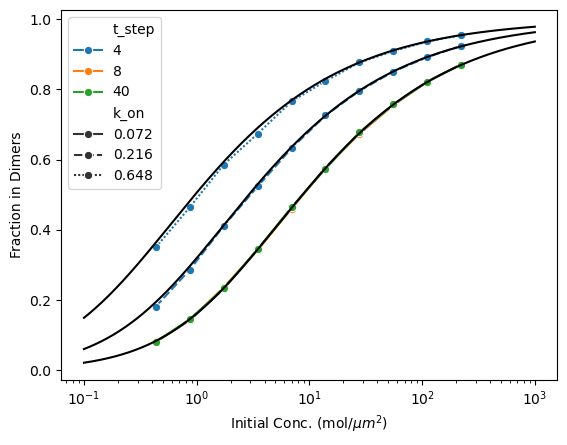

In [28]:
sns.lineplot(results,x='C_tot',y='dimer_eqm',hue='t_step',style='k_on',palette='tab10',marker='o')

for k_on in results['k_on'].unique():
    K_D = k_off/k_on
    C_tot = np.logspace(-1,3,1000)
    frac_dimer = 1 - ((-1 + np.sqrt(1+(8*C_tot)/K_D))/(4/K_D)/C_tot)
    plt.plot(C_tot,frac_dimer,'k-')
plt.semilogx()
plt.xlabel('Initial Conc. (mol/$\mu m^2$)')
plt.ylabel('Fraction in Dimers')

Text(0, 0.5, 'Initial rate of dimerization')

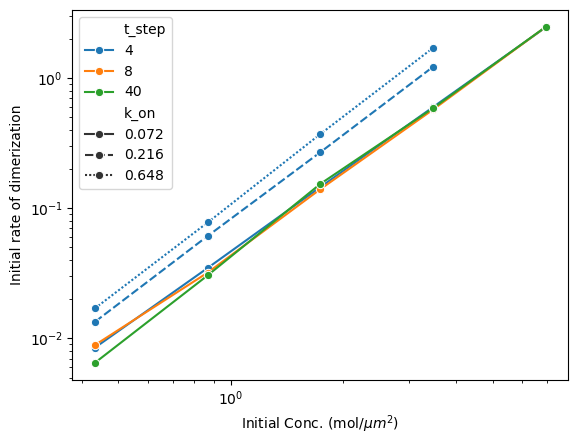

In [29]:
sns.lineplot(results[results['N_tp']>=5],x='C_tot',y='r_0',hue='t_step',style='k_on',palette='tab10',marker='o')

# for k_on in results['k_on'].unique():
#     C_tot = np.logspace(-0.5,1,1000)
#     rate = (k_on*C_tot**2)/4
#     plt.plot(C_tot,rate,'k-')
plt.loglog()
plt.xlabel('Initial Conc. (mol/$\mu m^2$)')
plt.ylabel('Initial rate of dimerization')

[]

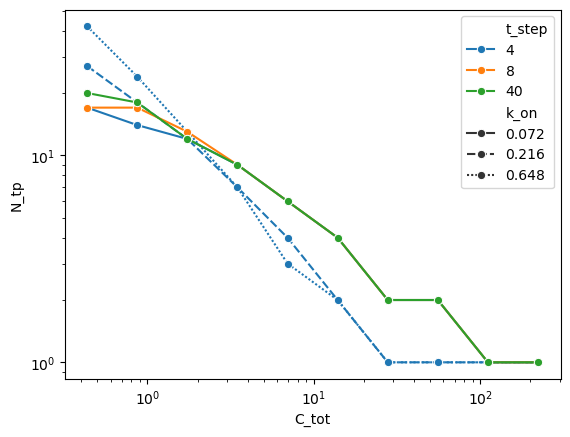

In [30]:
sns.lineplot(results,x='C_tot',y='N_tp',hue='t_step',style='k_on',palette='tab10',marker='o')
plt.loglog()

In [19]:
summary_di = {}
summary_di['time'] = T
for fr,frac in enumerate(frac_filled):
    for i,(t,on) in enumerate(zip(t_factor,on_factor)):
        size_distr = np.zeros([500,1201,5])
        nmol = np.zeros([500,1201])
        for j in range(N_job[i,fr]):
            size_distr[j*N_per[i,fr]:(j+1)*N_per[i,fr],:,:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                            'r')['cluster_size_distribution'][:]
            nmol[j*N_per[i,fr]:(j+1)*N_per[i,fr],:] = h5py.File(f'results/t{t}_on{on}_frac{fr}_{j}_summary_funcs.h5',
                                                            'r')['num_mols'][:]
        for r in range(5):
            summary_di[f't{t}_on{on}_frac{fr}_rep{r}'] = np.mean(nmol[100*r:100*(r+1)]*size_distr[100*r:100*(r+1),:,1]/((151*0.03)**2),axis=0)/2
summary_di = pd.DataFrame(summary_di)
summary_di.head()

,time,t4_on1_frac0_rep0,t4_on1_frac0_rep1,t4_on1_frac0_rep2,t4_on1_frac0_rep3,t4_on1_frac0_rep4,t4_on3_frac0_rep0,t4_on3_frac0_rep1,t4_on3_frac0_rep2,t4_on3_frac0_rep3,...,t8_on1_frac9_rep0,t8_on1_frac9_rep1,t8_on1_frac9_rep2,t8_on1_frac9_rep3,t8_on1_frac9_rep4,t40_on1_frac9_rep0,t40_on1_frac9_rep1,t40_on1_frac9_rep2,t40_on1_frac9_rep3,t40_on1_frac9_rep4
0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.025,0.0,0.000487,0.000487,0.000487,0.000000,0.000975,0.000487,0.000000,0.000000,...,47.068598,47.218689,47.223562,47.232821,47.027664,47.043746,47.333207,47.319562,47.287887,47.055441
2,0.050,0.0,0.001462,0.000975,0.000975,0.000000,0.001462,0.000975,0.000000,0.000487,...,64.908946,64.849495,64.988378,64.904561,65.005921,64.583912,65.175504,65.063910,64.837312,64.657983
3,0.075,0.0,0.001462,0.000975,0.000975,0.000487,0.001949,0.001949,0.000975,0.000975,...,74.378804,74.227251,74.345180,74.198987,74.353464,74.022582,74.472367,74.458723,74.196551,73.981161
4,0.100,0.0,0.001462,0.001462,0.000975,0.000487,0.002437,0.001949,0.001462,0.001462,...,80.043760,80.098339,80.020369,79.978948,80.066664,79.834705,80.155841,80.143171,79.970177,79.823984


In [20]:
summary_di.to_csv('dimer_vs_time.csv')

In [7]:
dt_base = 5e-4
dx = 0.03

info = {
    'D_LAT': D_LAT,
    'dt_base': dt_base,
    'k_off':k_unbind,
    'k_on_base': k_bind_base,
    'concs': list(np.array(frac_filled)/(dx**2)),
    't_factors':[1, 1, 1, 2, 10],
    'on_factors':[1, 3, 9, 1, 1]
}
info

{'D_LAT': 0.043125,
 'dt_base': 0.0005,
 'k_off': 0.00225,
 'k_on_base': 0.072,
 'concs': [0.4340277777777778,
  0.8680555555555556,
  1.7361111111111112,
  3.4722222222222223,
  6.944444444444445,
  13.88888888888889,
  27.77777777777778,
  55.55555555555556,
  111.11111111111111,
  222.22222222222223],
 't_factors': [1, 1, 1, 2, 10],
 'on_factors': [1, 3, 9, 1, 1]}

In [22]:
pkl.dump(info,open('rxn_kinetics_info.pkl','wb'))